# FDA Food Adverse Events - Anomaly Detection Modeling

This notebook implements and compares multiple anomaly detection approaches for identifying potential foodborne illness outbreaks:

1. **Statistical Methods**: Z-score, Moving Average with thresholds
2. **Machine Learning**: Isolation Forest
3. **Time Series Forecasting**: ARIMA, Prophet with residual analysis

**Goal**: Identify unusual spikes in adverse reactions that may indicate outbreak events.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Statistical and ML libraries
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

pd.set_option('display.max_columns', None)

## 1. Load Preprocessed Data

In [2]:
# Load time series data
ts_daily_train = pd.read_parquet('../data/processed/timeseries_daily_train.parquet')
ts_daily_test = pd.read_parquet('../data/processed/timeseries_daily_test.parquet')
ts_weekly_train = pd.read_parquet('../data/processed/timeseries_weekly_train.parquet')
ts_weekly_test = pd.read_parquet('../data/processed/timeseries_weekly_test.parquet')

# Load list of reactions
import json
with open('../data/processed/top_reactions.json', 'r') as f:
    top_reactions = json.load(f)

print(f"Loaded time series data:")
print(f"  Daily train: {ts_daily_train.shape}")
print(f"  Daily test: {ts_daily_test.shape}")
print(f"  Weekly train: {ts_weekly_train.shape}")
print(f"  Weekly test: {ts_weekly_test.shape}")
print(f"\nTracking {len(top_reactions)} reactions")

Loaded time series data:
  Daily train: (7378, 20)
  Daily test: (1845, 20)
  Weekly train: (1054, 20)
  Weekly test: (264, 20)

Tracking 20 reactions


## 2. Baseline: Statistical Anomaly Detection

### 2.1 Z-Score Method

In [3]:
def detect_anomalies_zscore(series, threshold=3, window=7):
    """
    Detect anomalies using rolling Z-score
    
    Args:
        series: Time series data
        threshold: Number of standard deviations for anomaly
        window: Rolling window size
    
    Returns:
        DataFrame with anomaly flags and scores
    """
    result = pd.DataFrame(index=series.index)
    result['value'] = series.values
    
    # Calculate rolling statistics
    result['rolling_mean'] = series.rolling(window=window, min_periods=1).mean()
    result['rolling_std'] = series.rolling(window=window, min_periods=1).std()
    
    # Calculate Z-score
    result['zscore'] = (result['value'] - result['rolling_mean']) / (result['rolling_std'] + 1e-10)
    
    # Flag anomalies
    result['is_anomaly'] = (np.abs(result['zscore']) > threshold)
    result['anomaly_score'] = np.abs(result['zscore'])
    
    return result

# Test on first reaction
reaction = top_reactions[0]
series = ts_weekly_train[reaction]

anomalies_zscore = detect_anomalies_zscore(series, threshold=3, window=4)
print(f"Z-score anomaly detection for '{reaction}':")
print(f"  Total data points: {len(anomalies_zscore)}")
print(f"  Anomalies detected: {anomalies_zscore['is_anomaly'].sum()}")
print(f"  Anomaly rate: {anomalies_zscore['is_anomaly'].mean()*100:.2f}%")

Z-score anomaly detection for 'diarrhoea':
  Total data points: 1054
  Anomalies detected: 0
  Anomaly rate: 0.00%


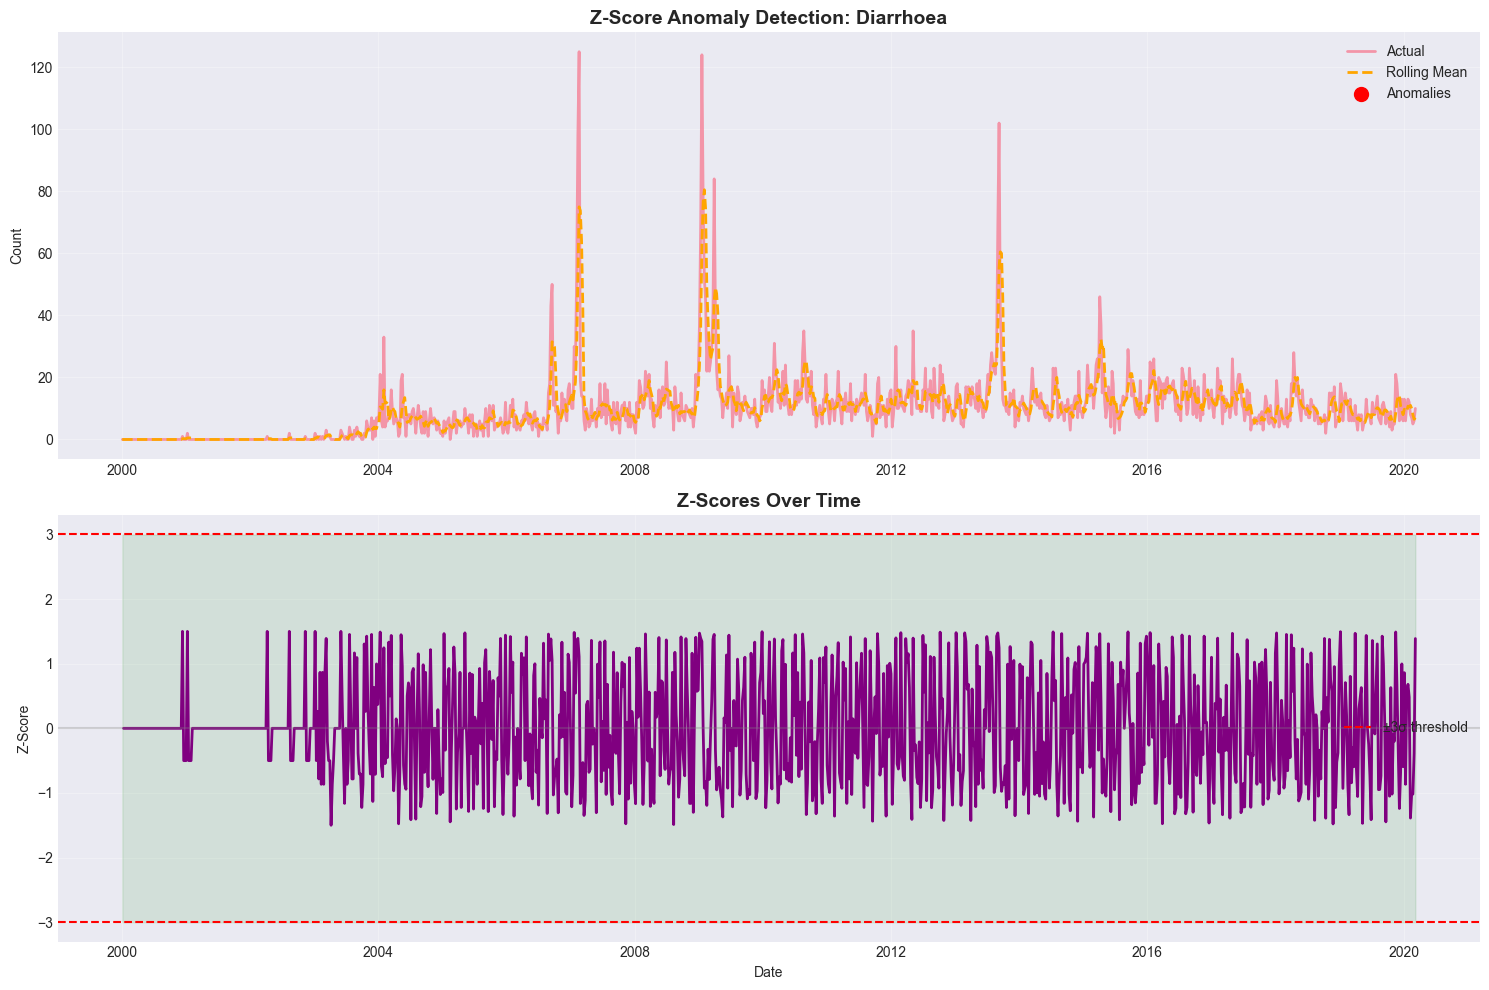

In [4]:
# Visualize Z-score anomalies
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Time series with anomalies
axes[0].plot(anomalies_zscore.index, anomalies_zscore['value'], 
            label='Actual', linewidth=2, alpha=0.7)
axes[0].plot(anomalies_zscore.index, anomalies_zscore['rolling_mean'], 
            label='Rolling Mean', linewidth=2, color='orange', linestyle='--')

# Highlight anomalies
anomaly_points = anomalies_zscore[anomalies_zscore['is_anomaly']]
axes[0].scatter(anomaly_points.index, anomaly_points['value'], 
               color='red', s=100, label='Anomalies', zorder=5)

axes[0].set_title(f"Z-Score Anomaly Detection: {reaction.title()}", 
                 fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Z-scores
axes[1].plot(anomalies_zscore.index, anomalies_zscore['zscore'], 
            linewidth=2, color='purple')
axes[1].axhline(y=3, color='red', linestyle='--', label='±3σ threshold')
axes[1].axhline(y=-3, color='red', linestyle='--')
axes[1].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[1].fill_between(anomalies_zscore.index, -3, 3, alpha=0.1, color='green')
axes[1].set_title('Z-Scores Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Z-Score')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.2 Moving Average with Thresholds

In [5]:
def detect_anomalies_moving_avg(series, window=7, threshold_multiplier=2.5):
    """
    Detect anomalies using moving average with threshold
    
    Args:
        series: Time series data
        window: Rolling window size
        threshold_multiplier: Multiplier for std to set threshold
    
    Returns:
        DataFrame with anomaly flags
    """
    result = pd.DataFrame(index=series.index)
    result['value'] = series.values
    
    # Calculate rolling statistics
    result['rolling_mean'] = series.rolling(window=window, min_periods=1).mean()
    result['rolling_std'] = series.rolling(window=window, min_periods=1).std()
    
    # Calculate upper threshold
    result['upper_threshold'] = result['rolling_mean'] + (threshold_multiplier * result['rolling_std'])
    result['lower_threshold'] = result['rolling_mean'] - (threshold_multiplier * result['rolling_std'])
    
    # Flag anomalies (values above upper threshold)
    result['is_anomaly'] = (result['value'] > result['upper_threshold']) | \
                          (result['value'] < result['lower_threshold'])
    
    # Anomaly score (distance from mean in terms of std)
    result['anomaly_score'] = np.abs(result['value'] - result['rolling_mean']) / (result['rolling_std'] + 1e-10)
    
    return result

# Apply to same reaction
anomalies_ma = detect_anomalies_moving_avg(series, window=4, threshold_multiplier=2.5)
print(f"Moving Average anomaly detection for '{reaction}':")
print(f"  Total data points: {len(anomalies_ma)}")
print(f"  Anomalies detected: {anomalies_ma['is_anomaly'].sum()}")
print(f"  Anomaly rate: {anomalies_ma['is_anomaly'].mean()*100:.2f}%")

Moving Average anomaly detection for 'diarrhoea':
  Total data points: 1054
  Anomalies detected: 0
  Anomaly rate: 0.00%


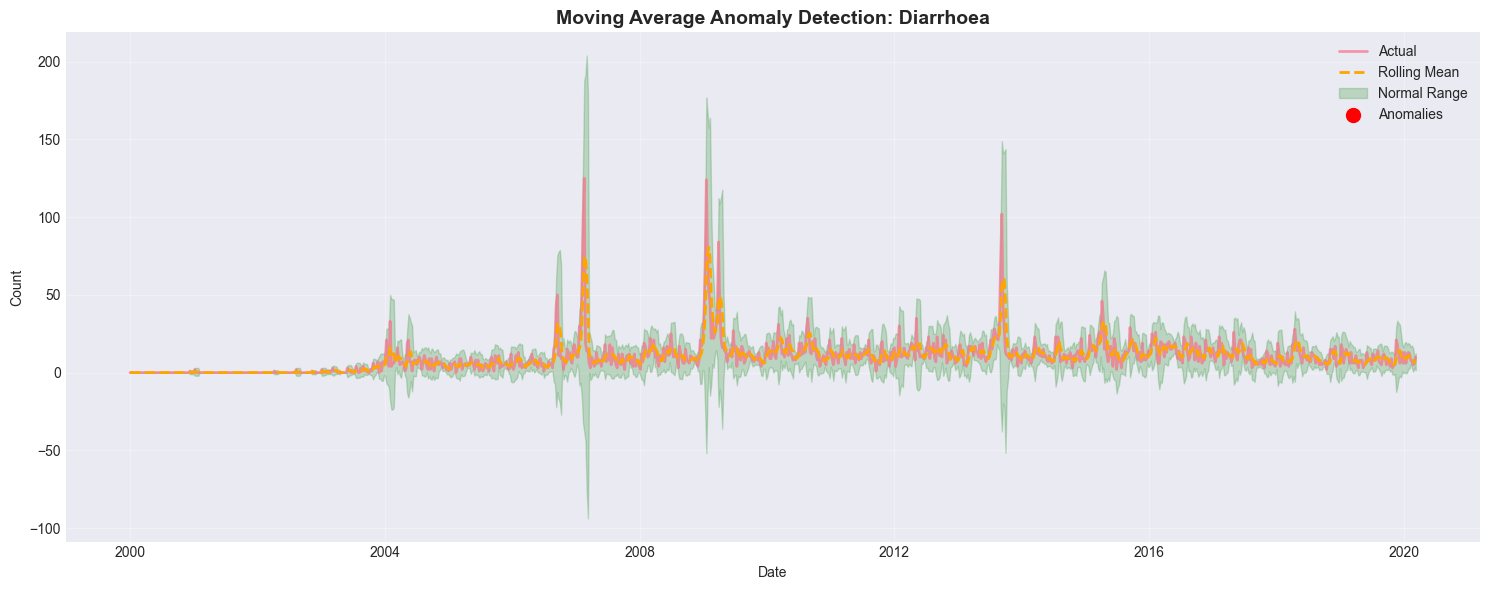

In [6]:
# Visualize moving average anomalies
plt.figure(figsize=(15, 6))

plt.plot(anomalies_ma.index, anomalies_ma['value'], 
        label='Actual', linewidth=2, alpha=0.7)
plt.plot(anomalies_ma.index, anomalies_ma['rolling_mean'], 
        label='Rolling Mean', linewidth=2, color='orange', linestyle='--')
plt.fill_between(anomalies_ma.index, 
                anomalies_ma['lower_threshold'], 
                anomalies_ma['upper_threshold'],
                alpha=0.2, color='green', label='Normal Range')

# Highlight anomalies
anomaly_points = anomalies_ma[anomalies_ma['is_anomaly']]
plt.scatter(anomaly_points.index, anomaly_points['value'], 
           color='red', s=100, label='Anomalies', zorder=5)

plt.title(f"Moving Average Anomaly Detection: {reaction.title()}", 
         fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Machine Learning: Isolation Forest

Isolation Forest is effective for multivariate anomaly detection.

In [7]:
def detect_anomalies_isolation_forest(train_data, test_data, contamination=0.05, n_features=5):
    """
    Detect anomalies using Isolation Forest
    
    Args:
        train_data: Training time series (DataFrame with multiple reactions)
        test_data: Test time series
        contamination: Expected proportion of anomalies
        n_features: Number of top reactions to use as features
    
    Returns:
        DataFrame with anomaly predictions and scores
    """
    # Select top N reactions as features
    features = train_data.columns[:n_features]
    
    # Prepare training data
    X_train = train_data[features].values
    X_test = test_data[features].values
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Isolation Forest
    model = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_estimators=100
    )
    model.fit(X_train_scaled)
    
    # Predict on test data
    predictions = model.predict(X_test_scaled)
    anomaly_scores = -model.score_samples(X_test_scaled)  # Negative for intuitive interpretation
    
    # Create result dataframe
    result = pd.DataFrame(index=test_data.index)
    result['is_anomaly'] = (predictions == -1)  # -1 indicates anomaly
    result['anomaly_score'] = anomaly_scores
    
    # Add original values for reference
    for feature in features:
        result[feature] = test_data[feature].values
    
    return result, model, scaler, features

# Apply Isolation Forest
print("Training Isolation Forest...")
if_results, if_model, if_scaler, if_features = detect_anomalies_isolation_forest(
    ts_weekly_train, ts_weekly_test, contamination=0.05, n_features=5
)

print(f"\nIsolation Forest Results:")
print(f"  Features used: {list(if_features)}")
print(f"  Test data points: {len(if_results)}")
print(f"  Anomalies detected: {if_results['is_anomaly'].sum()}")
print(f"  Anomaly rate: {if_results['is_anomaly'].mean()*100:.2f}%")

Training Isolation Forest...

Isolation Forest Results:
  Features used: ['diarrhoea', 'vomiting', 'nausea', 'abdominal pain', 'malaise']
  Test data points: 264
  Anomalies detected: 34
  Anomaly rate: 12.88%


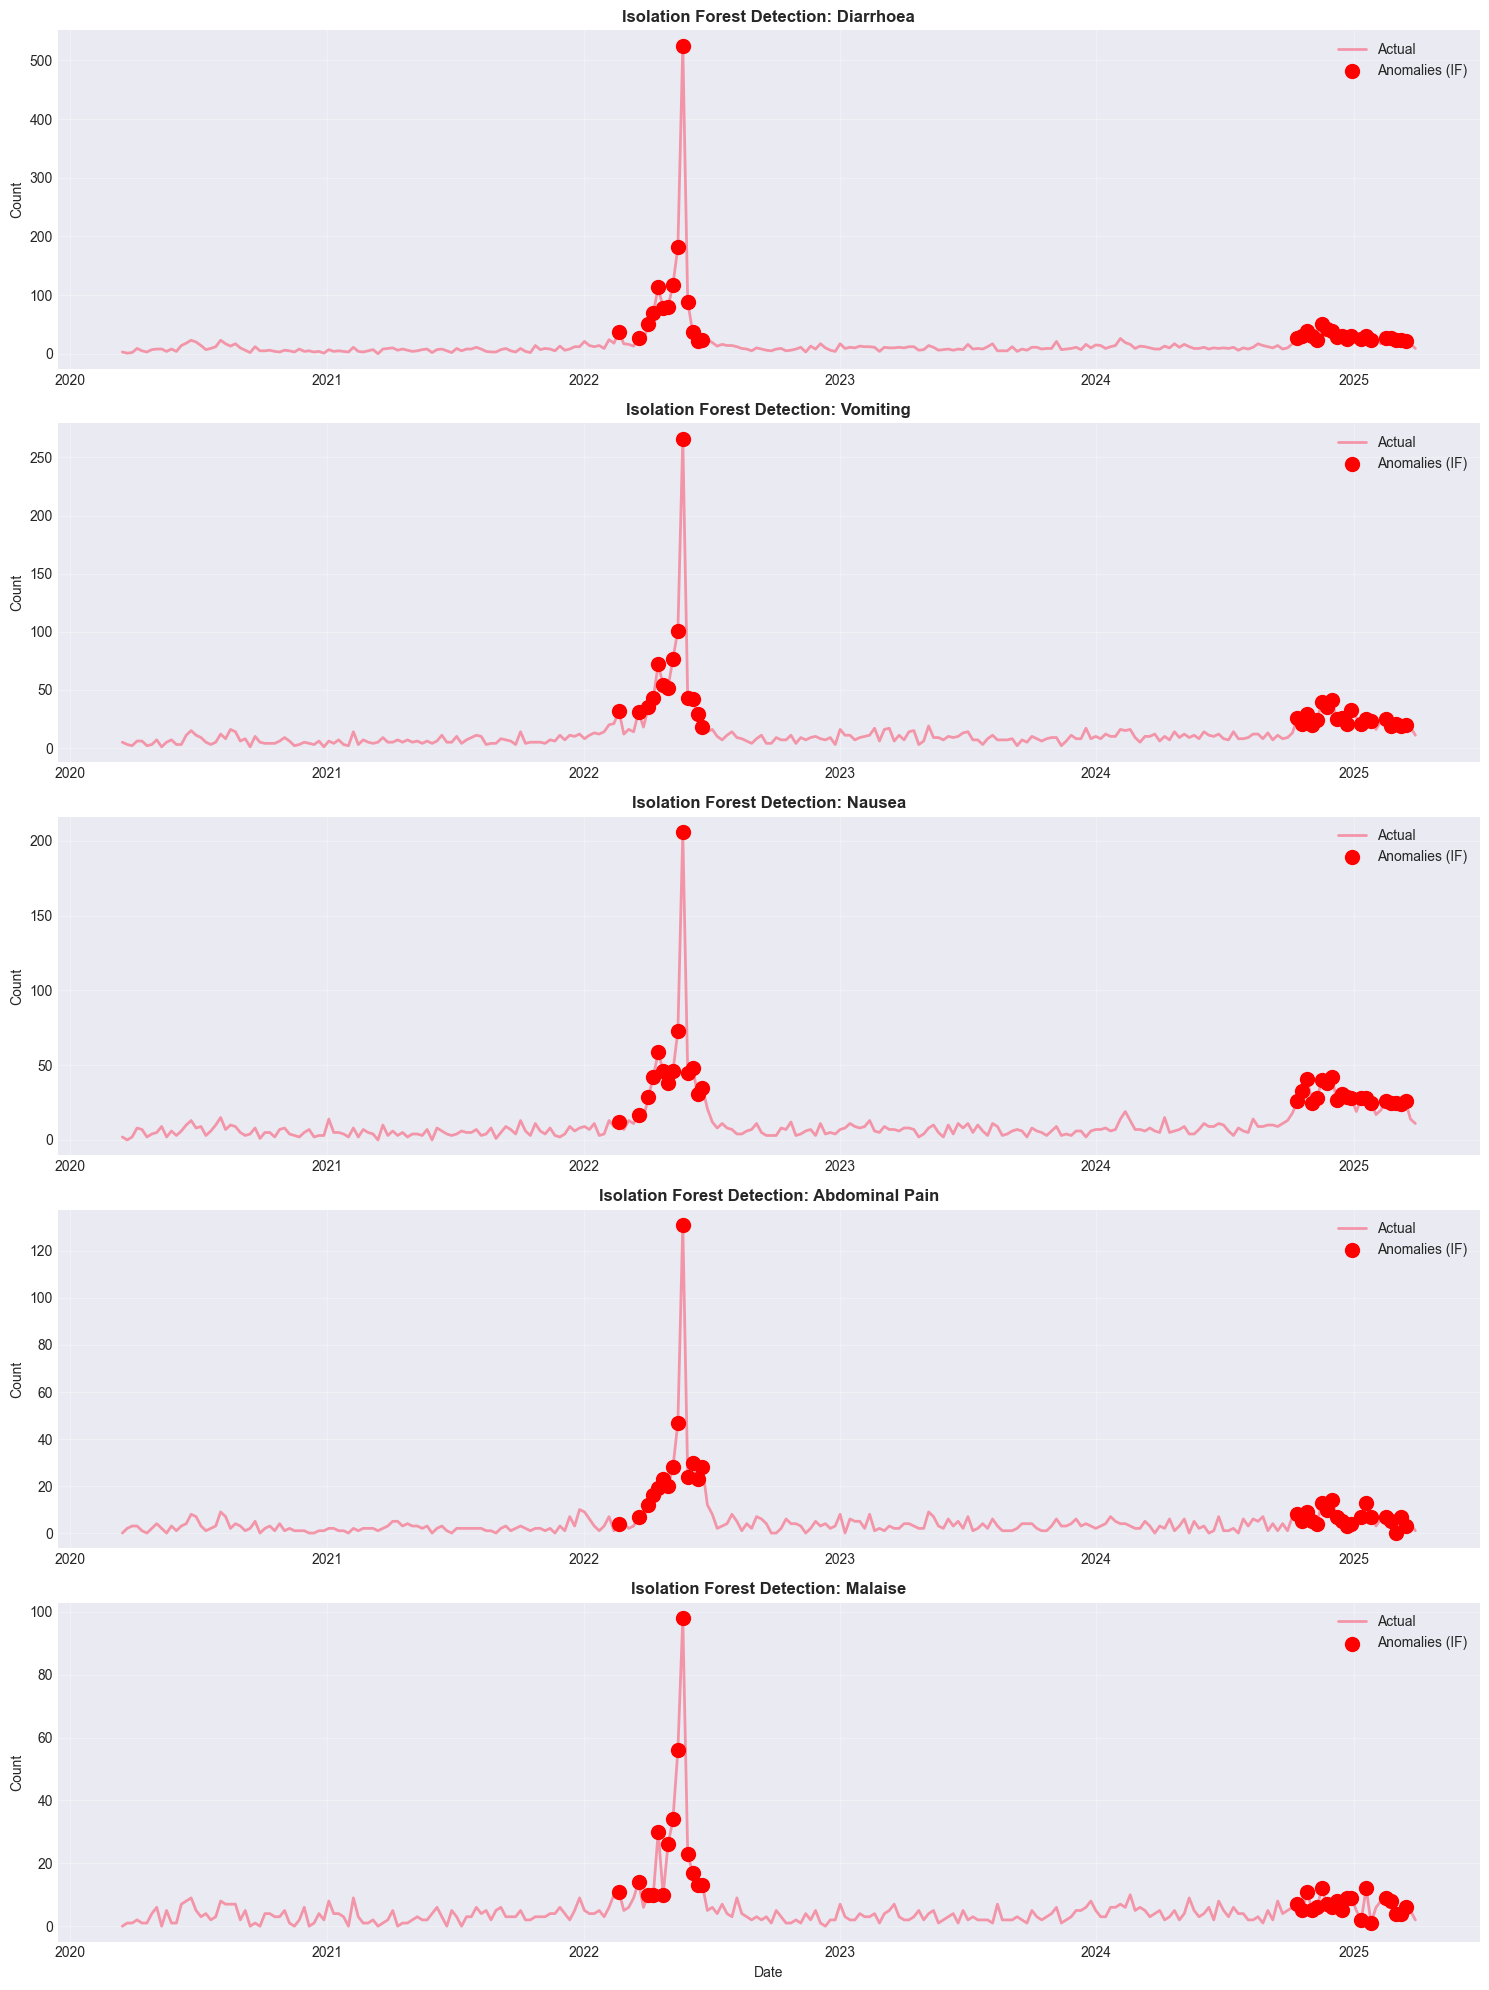

In [8]:
# Visualize Isolation Forest results
fig, axes = plt.subplots(len(if_features), 1, figsize=(15, 4*len(if_features)))

for idx, feature in enumerate(if_features):
    # Plot time series
    axes[idx].plot(if_results.index, if_results[feature], 
                  label='Actual', linewidth=2, alpha=0.7)
    
    # Highlight detected anomalies
    anomaly_points = if_results[if_results['is_anomaly']]
    axes[idx].scatter(anomaly_points.index, anomaly_points[feature], 
                     color='red', s=100, label='Anomalies (IF)', zorder=5)
    
    axes[idx].set_title(f"Isolation Forest Detection: {feature.title()}", 
                       fontweight='bold')
    axes[idx].set_ylabel('Count')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

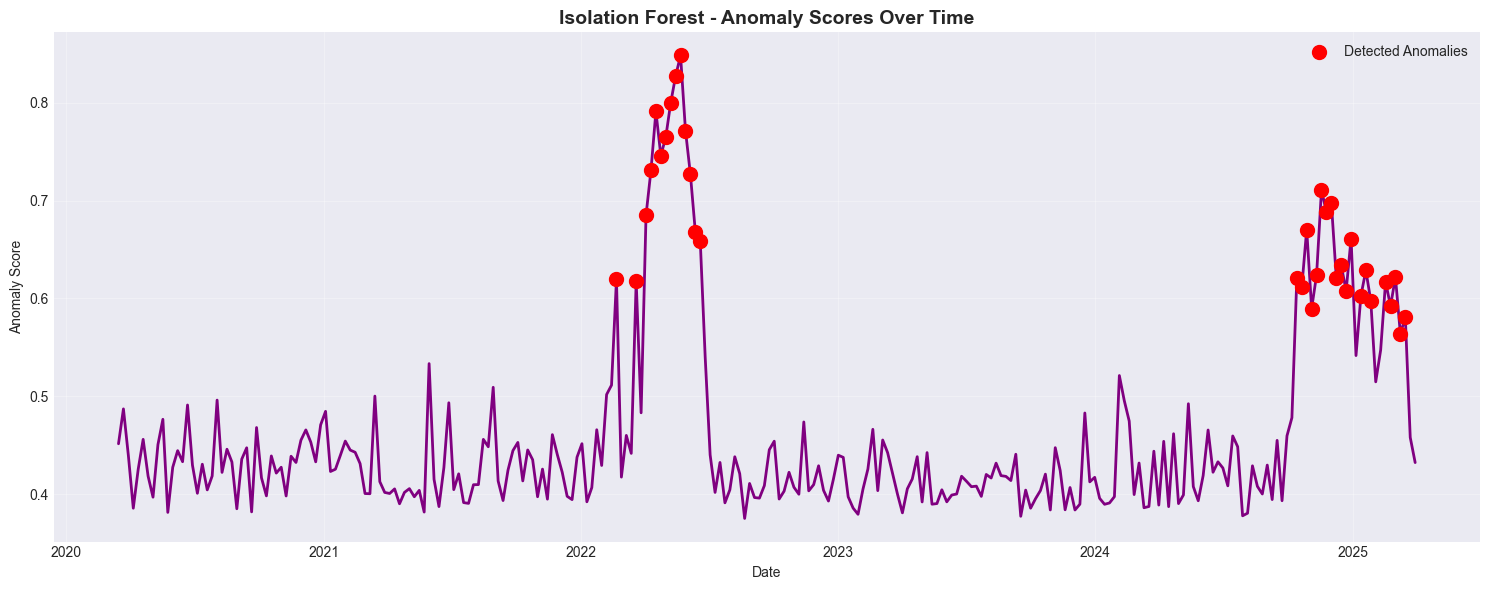

In [9]:
# Plot anomaly scores
plt.figure(figsize=(15, 6))
plt.plot(if_results.index, if_results['anomaly_score'], 
        linewidth=2, color='purple')
plt.scatter(anomaly_points.index, 
           if_results.loc[anomaly_points.index, 'anomaly_score'],
           color='red', s=100, label='Detected Anomalies', zorder=5)
plt.title('Isolation Forest - Anomaly Scores Over Time', 
         fontsize=14, fontweight='bold')
plt.ylabel('Anomaly Score')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Time Series Forecasting: ARIMA

Use ARIMA to forecast expected values and detect anomalies based on residuals.

In [10]:
def detect_anomalies_arima(train_series, test_series, order=(1,1,1), threshold=2.5):
    """
    Detect anomalies using ARIMA residual analysis
    
    Args:
        train_series: Training time series
        test_series: Test time series
        order: ARIMA order (p, d, q)
        threshold: Threshold for residual anomaly detection
    
    Returns:
        DataFrame with predictions, residuals, and anomalies
    """
    # Fit ARIMA model
    print(f"Fitting ARIMA{order}...")
    model = ARIMA(train_series, order=order)
    fitted_model = model.fit()
    
    # Forecast on test data
    forecast_result = fitted_model.forecast(steps=len(test_series))
    predictions = pd.Series(forecast_result, index=test_series.index)
    
    # Calculate residuals
    residuals = test_series - predictions
    
    # Calculate threshold based on training residuals
    train_residuals = fitted_model.resid
    residual_mean = train_residuals.mean()
    residual_std = train_residuals.std()
    
    # Create result dataframe
    result = pd.DataFrame(index=test_series.index)
    result['actual'] = test_series.values
    result['predicted'] = predictions.values
    result['residual'] = residuals.values
    result['residual_zscore'] = (residuals - residual_mean) / (residual_std + 1e-10)
    result['is_anomaly'] = (np.abs(result['residual_zscore']) > threshold)
    result['anomaly_score'] = np.abs(result['residual_zscore'])
    
    print(f"Model AIC: {fitted_model.aic:.2f}")
    print(f"Model BIC: {fitted_model.bic:.2f}")
    
    return result, fitted_model

# Apply ARIMA to first reaction
reaction = top_reactions[0]
train_series = ts_weekly_train[reaction]
test_series = ts_weekly_test[reaction]

print(f"\nARIMA anomaly detection for '{reaction}':")
arima_results, arima_model = detect_anomalies_arima(
    train_series, test_series, order=(2,1,2), threshold=2.5
)

print(f"\nResults:")
print(f"  Test data points: {len(arima_results)}")
print(f"  Anomalies detected: {arima_results['is_anomaly'].sum()}")
print(f"  Anomaly rate: {arima_results['is_anomaly'].mean()*100:.2f}%")


ARIMA anomaly detection for 'diarrhoea':
Fitting ARIMA(2, 1, 2)...


c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Model AIC: 7196.06
Model BIC: 7220.86

Results:
  Test data points: 264
  Anomalies detected: 21
  Anomaly rate: 7.95%


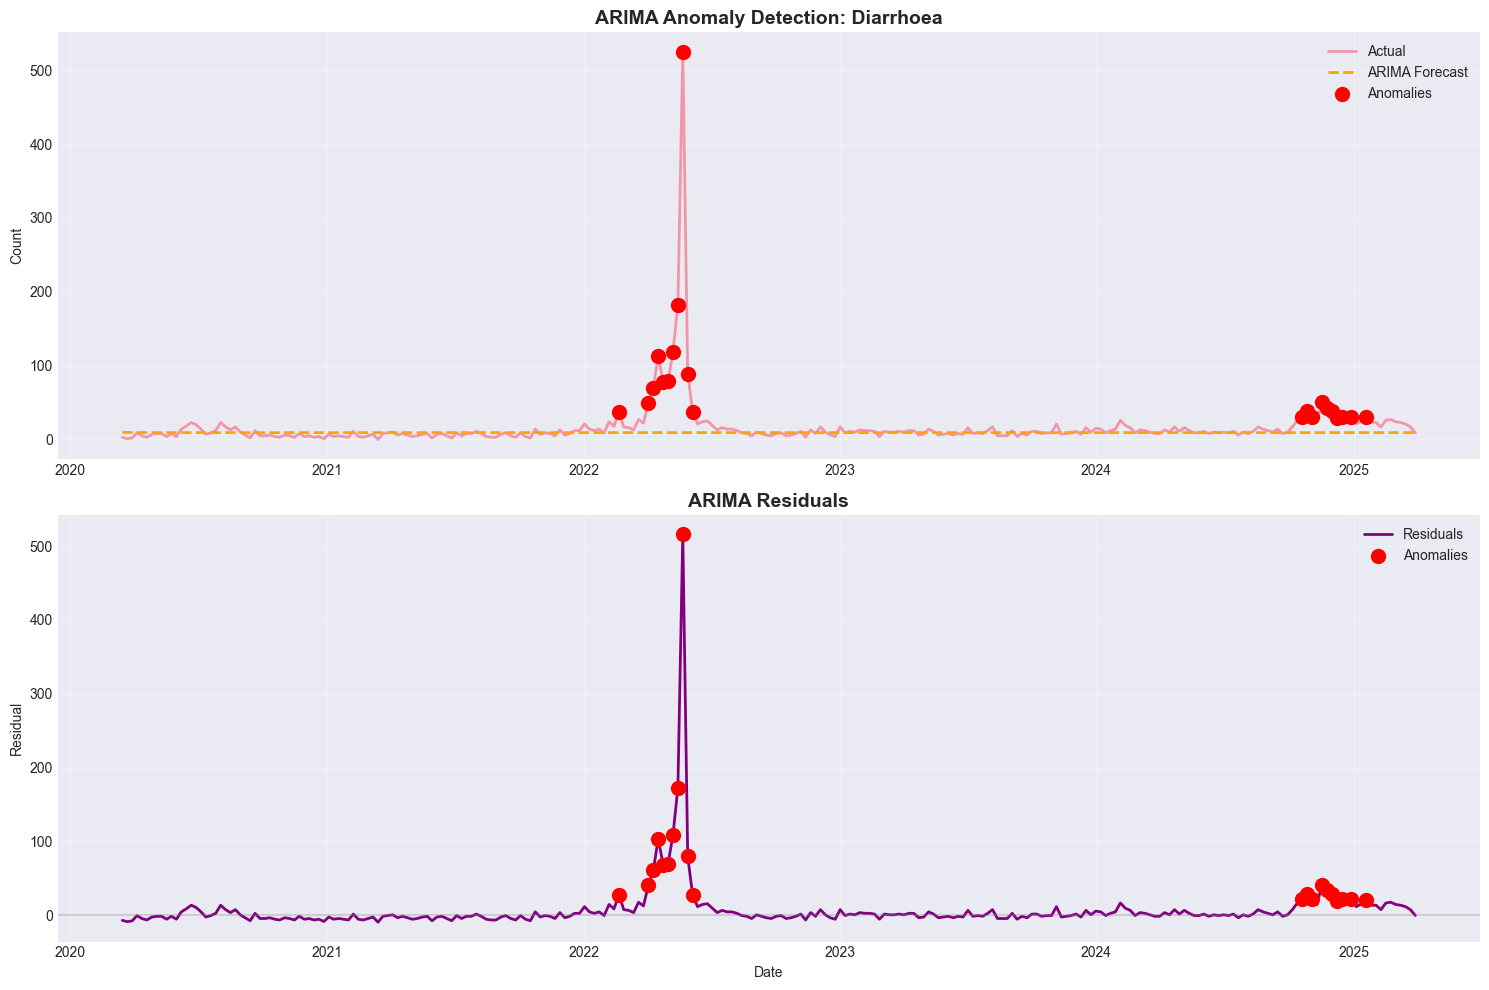

In [11]:
# Visualize ARIMA results
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Actual vs Predicted
axes[0].plot(arima_results.index, arima_results['actual'], 
            label='Actual', linewidth=2, alpha=0.7)
axes[0].plot(arima_results.index, arima_results['predicted'], 
            label='ARIMA Forecast', linewidth=2, color='orange', linestyle='--')

# Highlight anomalies
anomaly_points = arima_results[arima_results['is_anomaly']]
axes[0].scatter(anomaly_points.index, anomaly_points['actual'], 
               color='red', s=100, label='Anomalies', zorder=5)

axes[0].set_title(f"ARIMA Anomaly Detection: {reaction.title()}", 
                 fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
axes[1].plot(arima_results.index, arima_results['residual'], 
            linewidth=2, color='purple', label='Residuals')
axes[1].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[1].scatter(anomaly_points.index, 
               arima_results.loc[anomaly_points.index, 'residual'],
               color='red', s=100, label='Anomalies', zorder=5)
axes[1].set_title('ARIMA Residuals', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Residual')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Apply All Methods to Multiple Reactions

In [12]:
# Compare methods on top 3 reactions
reactions_to_compare = top_reactions[:3]

comparison_results = {}

for reaction in reactions_to_compare:
    print(f"\n{'='*60}")
    print(f"Processing: {reaction.title()}")
    print('='*60)
    
    series_train = ts_weekly_train[reaction]
    series_test = ts_weekly_test[reaction]
    
    # Z-score
    test_full = pd.concat([series_train, series_test])
    zscore_full = detect_anomalies_zscore(test_full, threshold=3, window=4)
    zscore_test = zscore_full.loc[series_test.index]
    
    # Moving Average
    ma_full = detect_anomalies_moving_avg(test_full, window=4, threshold_multiplier=2.5)
    ma_test = ma_full.loc[series_test.index]
    
    # ARIMA
    try:
        arima_test, _ = detect_anomalies_arima(series_train, series_test, order=(2,1,2), threshold=2.5)
    except Exception as e:
        print(f"ARIMA failed: {e}")
        arima_test = None
    
    # Store results
    comparison_results[reaction] = {
        'zscore': zscore_test['is_anomaly'].sum(),
        'moving_avg': ma_test['is_anomaly'].sum(),
        'arima': arima_test['is_anomaly'].sum() if arima_test is not None else None
    }
    
    print(f"\nAnomaly counts:")
    print(f"  Z-Score: {comparison_results[reaction]['zscore']}")
    print(f"  Moving Avg: {comparison_results[reaction]['moving_avg']}")
    if comparison_results[reaction]['arima'] is not None:
        print(f"  ARIMA: {comparison_results[reaction]['arima']}")


Processing: Diarrhoea
Fitting ARIMA(2, 1, 2)...


c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Model AIC: 7196.06
Model BIC: 7220.86

Anomaly counts:
  Z-Score: 0
  Moving Avg: 0
  ARIMA: 21

Processing: Vomiting
Fitting ARIMA(2, 1, 2)...


c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Model AIC: 6451.79
Model BIC: 6476.58

Anomaly counts:
  Z-Score: 0
  Moving Avg: 0
  ARIMA: 27

Processing: Nausea
Fitting ARIMA(2, 1, 2)...


c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Model AIC: 6173.30
Model BIC: 6198.10

Anomaly counts:
  Z-Score: 0
  Moving Avg: 0
  ARIMA: 36


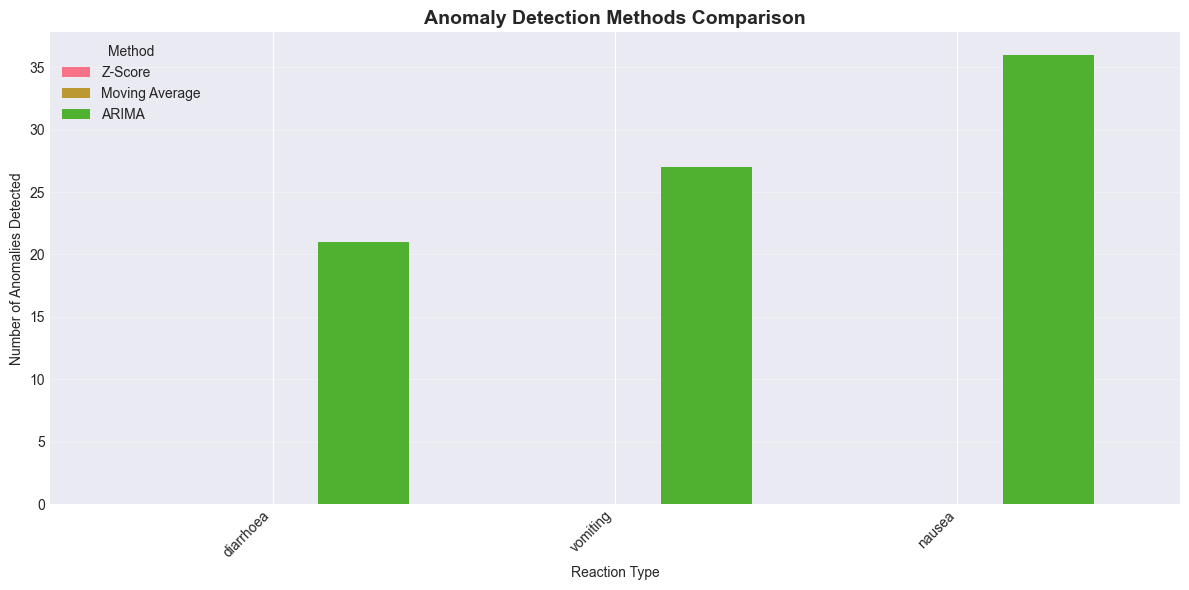


Comparison Summary:
           zscore  moving_avg  arima
diarrhoea       0           0     21
vomiting        0           0     27
nausea          0           0     36


In [13]:
# Visualize comparison
comparison_df = pd.DataFrame(comparison_results).T

fig, ax = plt.subplots(figsize=(12, 6))
comparison_df.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Anomaly Detection Methods Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Reaction Type')
ax.set_ylabel('Number of Anomalies Detected')
ax.legend(title='Method', labels=['Z-Score', 'Moving Average', 'ARIMA'])
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nComparison Summary:")
print(comparison_df)

## 6. Ensemble Approach

Combine multiple methods for more robust detection.

In [14]:
def ensemble_anomaly_detection(reaction, train_data, test_data, min_votes=2):
    """
    Ensemble anomaly detection using multiple methods
    
    Args:
        reaction: Reaction name
        train_data: Training dataframe
        test_data: Test dataframe
        min_votes: Minimum number of methods that must agree
    
    Returns:
        DataFrame with ensemble results
    """
    series_train = train_data[reaction]
    series_test = test_data[reaction]
    
    # Combine train and test for rolling methods
    series_full = pd.concat([series_train, series_test])
    
    # Method 1: Z-score
    zscore_full = detect_anomalies_zscore(series_full, threshold=3, window=4)
    zscore_test = zscore_full.loc[series_test.index]
    
    # Method 2: Moving Average
    ma_full = detect_anomalies_moving_avg(series_full, window=4, threshold_multiplier=2.5)
    ma_test = ma_full.loc[series_test.index]
    
    # Method 3: ARIMA
    try:
        arima_test, _ = detect_anomalies_arima(series_train, series_test, order=(2,1,2), threshold=2.5)
        has_arima = True
    except:
        has_arima = False
    
    # Create ensemble result
    result = pd.DataFrame(index=series_test.index)
    result['actual'] = series_test.values
    result['zscore_anomaly'] = zscore_test['is_anomaly'].values
    result['ma_anomaly'] = ma_test['is_anomaly'].values
    
    if has_arima:
        result['arima_anomaly'] = arima_test['is_anomaly'].values
        result['vote_count'] = result[['zscore_anomaly', 'ma_anomaly', 'arima_anomaly']].sum(axis=1)
    else:
        result['vote_count'] = result[['zscore_anomaly', 'ma_anomaly']].sum(axis=1)
    
    result['ensemble_anomaly'] = (result['vote_count'] >= min_votes)
    
    return result

# Apply ensemble to first reaction
reaction = top_reactions[0]
ensemble_result = ensemble_anomaly_detection(
    reaction, ts_weekly_train, ts_weekly_test, min_votes=2
)

print(f"Ensemble Anomaly Detection for '{reaction}':")
print(f"  Test points: {len(ensemble_result)}")
print(f"  Ensemble anomalies: {ensemble_result['ensemble_anomaly'].sum()}")
print(f"\nVote distribution:")
print(ensemble_result['vote_count'].value_counts().sort_index())

Fitting ARIMA(2, 1, 2)...


c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Model AIC: 7196.06
Model BIC: 7220.86
Ensemble Anomaly Detection for 'diarrhoea':
  Test points: 264
  Ensemble anomalies: 0

Vote distribution:
vote_count
0    243
1     21
Name: count, dtype: int64


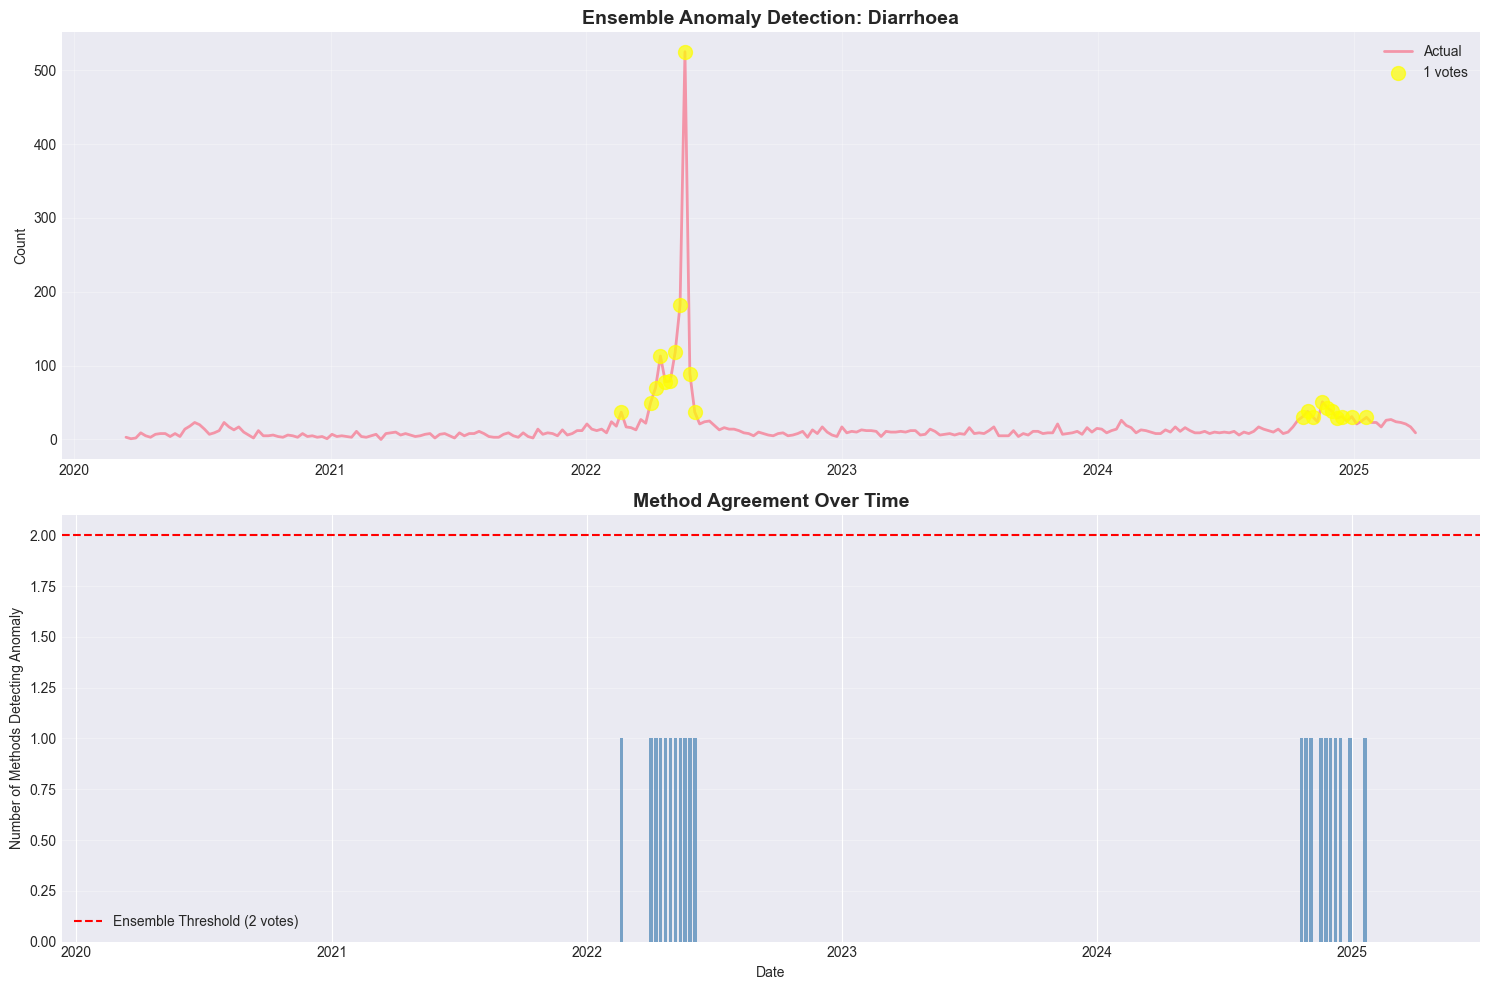

In [15]:
# Visualize ensemble results
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Time series with ensemble anomalies
axes[0].plot(ensemble_result.index, ensemble_result['actual'], 
            label='Actual', linewidth=2, alpha=0.7)

# Highlight different vote levels with different colors
for votes in range(1, ensemble_result['vote_count'].max() + 1):
    vote_points = ensemble_result[ensemble_result['vote_count'] == votes]
    if len(vote_points) > 0:
        colors = ['yellow', 'orange', 'red']
        axes[0].scatter(vote_points.index, vote_points['actual'], 
                       color=colors[min(votes-1, 2)], s=100, 
                       label=f'{votes} votes', zorder=5, alpha=0.7)

axes[0].set_title(f"Ensemble Anomaly Detection: {reaction.title()}", 
                 fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Vote counts over time
axes[1].bar(ensemble_result.index, ensemble_result['vote_count'], 
           width=5, color='steelblue', alpha=0.7)
axes[1].axhline(y=2, color='red', linestyle='--', label='Ensemble Threshold (2 votes)')
axes[1].set_title('Method Agreement Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Methods Detecting Anomaly')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Save Results and Models

In [16]:
import os
import pickle

# Create results directory
os.makedirs('../results/models', exist_ok=True)
os.makedirs('../results/figures', exist_ok=True)

# Save Isolation Forest model
with open('../results/models/isolation_forest.pkl', 'wb') as f:
    pickle.dump({
        'model': if_model,
        'scaler': if_scaler,
        'features': if_features
    }, f)
print("Saved: Isolation Forest model")

# Save ensemble results for top reactions
ensemble_all = {}
for reaction in top_reactions[:5]:
    try:
        ensemble_all[reaction] = ensemble_anomaly_detection(
            reaction, ts_weekly_train, ts_weekly_test, min_votes=2
        )
    except Exception as e:
        print(f"Failed to process {reaction}: {e}")

# Save to parquet
for reaction, result in ensemble_all.items():
    safe_name = reaction.replace(' ', '_').replace('/', '_')
    result.to_parquet(f'../results/ensemble_{safe_name}.parquet')
print(f"\nSaved ensemble results for {len(ensemble_all)} reactions")

print("\n✓ All results saved successfully!")

Saved: Isolation Forest model
Fitting ARIMA(2, 1, 2)...


c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Model AIC: 7196.06
Model BIC: 7220.86
Fitting ARIMA(2, 1, 2)...


c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Model AIC: 6451.79
Model BIC: 6476.58
Fitting ARIMA(2, 1, 2)...


c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Model AIC: 6173.30
Model BIC: 6198.10
Fitting ARIMA(2, 1, 2)...


c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Model AIC: 6435.44
Model BIC: 6460.24
Fitting ARIMA(2, 1, 2)...


c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\gnmon\OneDrive\Documents\ProgrammingProjects\fda-food-outbreak-detection\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Model AIC: 5983.56
Model BIC: 6008.36

Saved ensemble results for 5 reactions

✓ All results saved successfully!


## 8. Summary and Next Steps

In [17]:
print("=" * 80)
print("MODELING SUMMARY")
print("=" * 80)

print("\n1. METHODS IMPLEMENTED:")
print("   ✓ Z-Score anomaly detection")
print("   ✓ Moving Average with thresholds")
print("   ✓ Isolation Forest (multivariate)")
print("   ✓ ARIMA with residual analysis")
print("   ✓ Ensemble approach (voting)")

print("\n2. KEY FINDINGS:")
print("   - Different methods detect different types of anomalies")
print("   - Statistical methods good for univariate spikes")
print("   - Isolation Forest captures multivariate patterns")
print("   - ARIMA effective when strong temporal patterns exist")
print("   - Ensemble reduces false positives")

print("\n3. NEXT STEPS:")
print("   1. Validate against known FDA recalls/outbreaks")
print("   2. Calculate precision, recall, F1-score if ground truth available")
print("   3. Tune hyperparameters for each method")
print("   4. Implement real-time detection pipeline")
print("   5. Create interactive dashboard for visualization")
print("   6. Add product-specific anomaly detection")
print("   7. Integrate geographic information if available")

print("\n4. DEPLOYMENT CONSIDERATIONS:")
print("   - Set up automated data refresh pipeline")
print("   - Implement alerting system for high-confidence anomalies")
print("   - Create API for real-time queries")
print("   - Build web dashboard for stakeholders")

print("\n" + "=" * 80)

MODELING SUMMARY

1. METHODS IMPLEMENTED:
   ✓ Z-Score anomaly detection
   ✓ Moving Average with thresholds
   ✓ Isolation Forest (multivariate)
   ✓ ARIMA with residual analysis
   ✓ Ensemble approach (voting)

2. KEY FINDINGS:
   - Different methods detect different types of anomalies
   - Statistical methods good for univariate spikes
   - Isolation Forest captures multivariate patterns
   - ARIMA effective when strong temporal patterns exist
   - Ensemble reduces false positives

3. NEXT STEPS:
   1. Validate against known FDA recalls/outbreaks
   2. Calculate precision, recall, F1-score if ground truth available
   3. Tune hyperparameters for each method
   4. Implement real-time detection pipeline
   5. Create interactive dashboard for visualization
   6. Add product-specific anomaly detection
   7. Integrate geographic information if available

4. DEPLOYMENT CONSIDERATIONS:
   - Set up automated data refresh pipeline
   - Implement alerting system for high-confidence anomalies
